# Capstone Project - Automobile Accident Severity Predictor
## Trent Barron
### October 20, 2020

<a id="TOC"></a>

## Table of contents
[Executive Summary](#Exec)  

[Introduction: Business Understanding](#introduction)  

[Methodology](#methodology)  
    &nbsp;&nbsp;[Data Understanding](#understanding)  
    &nbsp;&nbsp;[Data Preparation](#prep)   
    &nbsp;&nbsp;[Data Modeling](#modeling)  
    &nbsp;&nbsp;&nbsp;[*Decision Tree](#DTree)  
    &nbsp;&nbsp;&nbsp;[*Logistic Regression](#LogReg)  
    &nbsp;&nbsp;&nbsp;[*K-Nearest Neighbor](#KNN)  
    &nbsp;&nbsp;&nbsp;[*Support Vector Machine](#SVM)  
[Results](#eval)  

[Discussion & Conclusion](#results)  

<a id="Exec"></a>

# Executive Summary

<a id="introduction"></a>

## Introduction: Business Understanding

The purpose of this project is to develop a predictor tool that can predict the severity of a traffic accident based on various scenarios that affect driving conditions, specifically weather, road, and light conditions.  The tool will provide highway travelers the means to determine if current travel conditions may increase the severity of a traffic accident and help them adjust their travel plans based on their risk profile.  This project utilizes the CRISP-DM methodology to analyze data provided by the Transportation Department of the City of Seattle and industry best practice machine learning techniques to model and validate the predictor tool.  Various classifiers will be evaluated to determine the which makes the the best predictor tool.  The classifers that will be evaluated are Decision Tree (DTree), Logistic Regression (LogReg), K-Nearest Neighbor (KNN), and Support Vector Machine (SVM).

In [1]:
# import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#load Seattle DOT dataset
rawdata=pd.read_csv('Data-Collisions.csv', low_memory=False)
# Check the cardinality of the dataset
print('Dataset shape:', rawdata.shape)

Dataset shape: (194673, 38)


<a id="methodology"></a>

## Methodology 

[Home](#TOC)

<a id="understanding"></a>

### Data Understanding 

The dataset used for this predictor is provided by the Transportation Department of the City of Seattle and was retrieved from the site Seattle GeoData.  This dataset provides a range of information on documented collisions that have taken place in the City of Seattle, WA.  It is important to review the attributes of this dataset and determine what data is relevant to our predictor. After reviewing the descriptions of the attributes provided in the dataset, it is apparent that SEVERITYCODE, WEATHER, ROADCOND, and LIGHTCOND are the attributes that we should focus on. The SEVERITYCODE provides 5 different codes that correspond to five different “severities”: 3=fatality, 2b=serious injury, 2=injury, 1=property damage, and 0=unknown.  WEATHER provides a description of the weather conditions during the time of the collision, ROADCOND provides a description of the road conditions during the collision, and LIGHTCOND provides the light conditions during the collision.  Each one of these attributes will need to be investigated further during data preparation to ensure there is no questionable, missing, or ambiguous data.

In [2]:
rawdata.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


We need to understand what format each of our attributes is in.  To do this we will run a list of data types for each column in "df."

In [3]:
# list the data types for each column
print(rawdata.dtypes)

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

I would also like to take a closer look at the unique values of each of the features that I think should be used for the predictor tool. 

In [4]:
print('SEVERITYCODE unique values:', rawdata['SEVERITYCODE'].unique())
print('SEVERITYDESC unique values:', rawdata['SEVERITYDESC'].unique())
print('WEATHER unique values:', rawdata['WEATHER'].unique())
print('ROADCOND unique values:', rawdata['ROADCOND'].unique())
print('LIGHTCOND unique values:', rawdata['LIGHTCOND'].unique())

SEVERITYCODE unique values: [2 1]
SEVERITYDESC unique values: ['Injury Collision' 'Property Damage Only Collision']
WEATHER unique values: ['Overcast' 'Raining' 'Clear' nan 'Unknown' 'Other' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt'
 'Severe Crosswind' 'Partly Cloudy']
ROADCOND unique values: ['Wet' 'Dry' nan 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']
LIGHTCOND unique values: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' nan
 'Unknown' 'Dusk' 'Dawn' 'Dark - Street Lights Off' 'Other'
 'Dark - Unknown Lighting']


It is interesting to note that there are only severity codes that indicate 'Injury Collision' (2) 'Property Damage Only Collision' (1).  This limitation impact the range that the predictor tool will be able to forecast.

Lets get a better understanding of the conditions we are looking at by finding out how many of each unique values we have.  In each case we will create a dataframe for each group.

In [5]:
weather_counts = rawdata['WEATHER'].value_counts().to_frame()
weather_counts

,WEATHER
Clear,111135
Raining,33145
Overcast,27714
Unknown,15091
Snowing,907
Other,832
Fog/Smog/Smoke,569
Sleet/Hail/Freezing Rain,113
Blowing Sand/Dirt,56
Severe Crosswind,25


In [6]:
road_counts = rawdata['ROADCOND'].value_counts().to_frame()
road_counts

,ROADCOND
Dry,124510
Wet,47474
Unknown,15078
Ice,1209
Snow/Slush,1004
Other,132
Standing Water,115
Sand/Mud/Dirt,75
Oil,64


In [7]:
light_counts = rawdata['LIGHTCOND'].value_counts().to_frame()
light_counts

,LIGHTCOND
Daylight,116137
Dark - Street Lights On,48507
Unknown,13473
Dusk,5902
Dawn,2502
Dark - No Street Lights,1537
Dark - Street Lights Off,1199
Other,235
Dark - Unknown Lighting,11


At this point it would be good to understand how the variables WEATHER, ROADCOND, AND LIGHTCOND are correlated to severity code.  For this I will uses the Analysis of Variance (ANOVA), a statistical method used to test whether there are significant differences between the means of two or more groups.  This will be used because the attributes contain categorical variables rather than numerical variables.

First we will isolate the attributes we want to analyze into a separate data frame.   

In [8]:
#Group variables
rawdata_anova = rawdata[['WEATHER','ROADCOND','LIGHTCOND','SEVERITYCODE','SEVERITYDESC']]
rawdata_anova

,WEATHER,ROADCOND,LIGHTCOND,SEVERITYCODE,SEVERITYDESC
0,Overcast,Wet,Daylight,2,Injury Collision
1,Raining,Wet,Dark - Street Lights On,1,Property Damage Only Collision
2,Overcast,Dry,Daylight,1,Property Damage Only Collision
3,Clear,Dry,Daylight,1,Property Damage Only Collision
4,Raining,Wet,Daylight,2,Injury Collision
...,...,...,...,...,...
194668,Clear,Dry,Daylight,2,Injury Collision
194669,Raining,Wet,Daylight,1,Property Damage Only Collision
194670,Clear,Dry,Daylight,2,Injury Collision
194671,Clear,Dry,Dusk,2,Injury Collision


Next we will identify the unique variables and determine which ones are ambiguous and exclude them from the analysis.

In [9]:
#analyze WEATHER
grouped_weather=rawdata_anova[['WEATHER', 'SEVERITYDESC', 'SEVERITYCODE']].groupby(['WEATHER'])
grouped_weather.head(1)

,WEATHER,SEVERITYDESC,SEVERITYCODE
0,Overcast,Injury Collision,2
1,Raining,Property Damage Only Collision,1
3,Clear,Property Damage Only Collision,1
15,NaN,Property Damage Only Collision,1
19,Unknown,Property Damage Only Collision,1
34,Other,Property Damage Only Collision,1
290,Snowing,Property Damage Only Collision,1
706,Fog/Smog/Smoke,Injury Collision,2
799,Sleet/Hail/Freezing Rain,Property Damage Only Collision,1
2238,Blowing Sand/Dirt,Property Damage Only Collision,1


Of the unique values of WEATHER, 'Other', 'Unknown' and 'NaN' are ambiguous because they will not provide meaningful information to the model.  These unique values will be omitted from the ANOVA analysis.

We will now use the method "get_group" to group the data by each unique value for the purpose of ANOVA.

In [10]:
# ANOVA: WEATHER
#import stats

f_val, p_val = stats.f_oneway(grouped_weather.get_group('Overcast')['SEVERITYCODE'], grouped_weather.get_group('Raining')['SEVERITYCODE'], 
                              grouped_weather.get_group('Clear')['SEVERITYCODE'],grouped_weather.get_group('Snowing')['SEVERITYCODE'],
                              grouped_weather.get_group('Fog/Smog/Smoke')['SEVERITYCODE'],grouped_weather.get_group('Sleet/Hail/Freezing Rain')['SEVERITYCODE'],
                              grouped_weather.get_group('Blowing Sand/Dirt')['SEVERITYCODE'],grouped_weather.get_group('Severe Crosswind')['SEVERITYCODE'],
                              grouped_weather.get_group('Partly Cloudy')['SEVERITYCODE'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)  

ANOVA results: F= 14.78219963145612 , P = 7.727373580982942e-22


ANOVA returns two parameters:

    F-test score: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score indicates a larger difference between the means.

    P-value: P-value tells how statistically significant is our calculated score value.

If our SEVERITYCODE variable is strongly correlated with the variable we are analyzing (WEATHER, ROADCOND, or LIGHTCOND), we would expect ANOVA to return a large F-test score and a small p-value (near zero).

In the case of WEATHER the F-score of nearly 15 and p-value of near zero indicates that we can be certain there is a statistical significance between WEATHER and SEVERITYCODE.  Typically we would analyze the correlation within the group, i.e. Overcast to Raining, Clear to Snowing, but at this point we only need to validate that the attributes are meaningful.

We will now repeat this process for ROADCOND and LIGHTCOND to determine their statistical significance.  

In [11]:
#analyze ROADCOND
grouped_roadcond=rawdata_anova[['ROADCOND', 'SEVERITYCODE']].groupby(['ROADCOND'])
grouped_roadcond.head(1)

,ROADCOND,SEVERITYCODE
0,Wet,2
2,Dry,1
15,NaN,1
23,Unknown,1
682,Snow/Slush,1
799,Ice,1
2754,Other,1
3336,Sand/Mud/Dirt,2
3353,Standing Water,2
3942,Oil,2


In [12]:
# ANOVA: ROADOND. Omit NaN, Unknown, and Other
f_val, p_val = stats.f_oneway(grouped_roadcond.get_group('Wet')['SEVERITYCODE'], 
                              grouped_roadcond.get_group('Dry')['SEVERITYCODE'], 
                              grouped_roadcond.get_group('Snow/Slush')['SEVERITYCODE'],
                              grouped_roadcond.get_group('Ice')['SEVERITYCODE'],
                              grouped_roadcond.get_group('Sand/Mud/Dirt')['SEVERITYCODE'],
                              grouped_roadcond.get_group('Standing Water')['SEVERITYCODE'],
                              grouped_roadcond.get_group('Oil')['SEVERITYCODE'],
                             )  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)  

ANOVA results: F= 30.99357510599123 , P = 1.92609849284034e-37


In [13]:
#analyze LIGHTCOND
grouped_lightcond=rawdata_anova[['LIGHTCOND', 'SEVERITYCODE']].groupby(['LIGHTCOND'])
grouped_lightcond.head(1)

,LIGHTCOND,SEVERITYCODE
0,Daylight,2
1,Dark - Street Lights On,1
13,Dark - No Street Lights,1
15,NaN,1
19,Unknown,1
56,Dusk,2
89,Dawn,2
175,Dark - Street Lights Off,2
197,Other,1
437,Dark - Unknown Lighting,1


In [14]:
# ANOVA: LIGHTOND. Omit NaN, Unknown, Dark - Unknown Lighting and Other
f_val, p_val = stats.f_oneway(grouped_lightcond.get_group('Daylight')['SEVERITYCODE'], 
                              grouped_lightcond.get_group('Dark - Street Lights On')['SEVERITYCODE'], 
                              grouped_lightcond.get_group('Dark - No Street Lights')['SEVERITYCODE'],
                              grouped_lightcond.get_group('Dusk')['SEVERITYCODE'],
                              grouped_lightcond.get_group('Dawn')['SEVERITYCODE'],
                              grouped_lightcond.get_group('Dark - Street Lights Off')['SEVERITYCODE'],
                              )  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)  

ANOVA results: F= 54.74957134205072 , P = 4.86674379866269e-57


After running ANOVA on the three attributes it looks like they are statistically significant to SEVERITYCODE.  I would like to point out that I deemed 'Dark-Unkown Lighting' as an ambiguous value in LIGHTCOND.  We wil now begin the data prepartion process. 

<a id='prep'></a>

### Data Preparation 

[Home](#TOC)

Undertanding the unique values of the atributes points out some ambiguous data. Categories such as "other" and "unknown" will not provide meaningful information for the predictor tool and need to be "cleaned" from the dataset.  I will create a more concise dataframe with only the Severity Code, Weather, Roadcond, and Lightcond attributes.  I will then replace "Other", "Unknown" and "Dark - Unknown Lighting" with NaN then remove rows that do not have values.

In [15]:
#Create data frame with only required attributes
df=rawdata[['SEVERITYCODE', 'SEVERITYDESC','WEATHER','ROADCOND','LIGHTCOND']]


In [16]:
# replace other to NaN
df.replace("Other", np.nan, inplace = True)
# replace unknown to NaN
df.replace("Unknown", np.nan, inplace = True)
# replace Dark - Unknown Lighting to NaN
df.replace("Dark - Unknown Lighting", np.nan, inplace = True)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [17]:
#Determine where there are null values
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64

SEVERITYDESC
False    194673
Name: SEVERITYDESC, dtype: int64

WEATHER
False    173669
True      21004
Name: WEATHER, dtype: int64

ROADCOND
False    174451
True      20222
Name: ROADCOND, dtype: int64

LIGHTCOND
False    175784
True      18889
Name: LIGHTCOND, dtype: int64



The missing data, indicated as 'True' values, is only about 10% of the total entries so deleting the rows with missing data will not be detremental to the integrity of the dataset.

In [18]:
# drop whole row with NaN in "SEVERITYCODE", "WEATHER", "ROADCOND" AND "LIGHTCOND" column and check results
df.dropna(subset=["SEVERITYCODE", 'SEVERITYDESC',"WEATHER", "ROADCOND","LIGHTCOND"], axis=0, inplace=True)
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

SEVERITYCODE
False    169949
Name: SEVERITYCODE, dtype: int64

SEVERITYDESC
False    169949
Name: SEVERITYDESC, dtype: int64

WEATHER
False    169949
Name: WEATHER, dtype: int64

ROADCOND
False    169949
Name: ROADCOND, dtype: int64

LIGHTCOND
False    169949
Name: LIGHTCOND, dtype: int64



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now let's validate that the ambiguous entries have been removed from "df".

In [19]:
df_weather_counts = df['WEATHER'].value_counts().to_frame()
df_weather_counts

,WEATHER
Clear,108822
Raining,32644
Overcast,26922
Snowing,825
Fog/Smog/Smoke,553
Sleet/Hail/Freezing Rain,107
Blowing Sand/Dirt,46
Severe Crosswind,25
Partly Cloudy,5


In [20]:
df_road_counts = df['ROADCOND'].value_counts().to_frame()
df_road_counts

,ROADCOND
Dry,121487
Wet,46319
Ice,1080
Snow/Slush,833
Standing Water,105
Sand/Mud/Dirt,65
Oil,60


In [21]:
df_light_counts = df['LIGHTCOND'].value_counts().to_frame()
df_light_counts

,LIGHTCOND
Daylight,112618
Dark - Street Lights On,46748
Dusk,5648
Dawn,2413
Dark - No Street Lights,1408
Dark - Street Lights Off,1114


Success.  

At this point, I want to review the data types of our key attributes that will be modeled for our predictor tool.  Doing so reveals that WEATHER, RODCOND, and LIGHTCOND are object data types while SEVERITYCODE is an interger type. It may also be helpful to have the shape of the data frame.

In [22]:
# View attribbutes
print(df.dtypes)
print(df.shape)
print(df.columns)

SEVERITYCODE     int64
SEVERITYDESC    object
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object
(169949, 5)
Index(['SEVERITYCODE', 'SEVERITYDESC', 'WEATHER', 'ROADCOND', 'LIGHTCOND'], dtype='object')


#### Preprocessing  

First we will defin X and y by splitting our dataset into X and y values that Sklearn can accept.

In this case we want to be able to predict a SEVERITYDESC based on WEATHER, ROADCOND, and LIGHTCOND so we need to make y =  SEVERITYDESC and X equal the matrix containing the features WEATHER, ROADCOND, and LIGHTCOND.

In [23]:
#acceptable inputs for sklearn fit method
X=df[['WEATHER', 'ROADCOND', 'LIGHTCOND']].values
y=df[['SEVERITYDESC']].values
print('X, the samples matrix:', X)
print('y, the target values:', y)


X, the samples matrix: [['Overcast' 'Wet' 'Daylight']
 ['Raining' 'Wet' 'Dark - Street Lights On']
 ['Overcast' 'Dry' 'Daylight']
 ...
 ['Clear' 'Dry' 'Daylight']
 ['Clear' 'Dry' 'Dusk']
 ['Clear' 'Wet' 'Daylight']]
y, the target values: [['Injury Collision']
 ['Property Damage Only Collision']
 ['Property Damage Only Collision']
 ...
 ['Injury Collision']
 ['Injury Collision']
 ['Property Damage Only Collision']]


Because many of the Sklearn classifiers not handle categorical variables, we need to convert the features matrix elements to numerical values. The best way to do this is to use pandas.get_dummies() function to convert these categorical variables into dummy/indicator variables. This is done with the preprocessing functions of Sklearn.  After they are transformed we will review the changes in the X values to ensure that the catergorical variables have been converted to indicator variables (numbers).

In [24]:
from sklearn import preprocessing
le_weather = preprocessing.LabelEncoder()
le_weather.fit(['Overcast','Raining','Clear','Unknown','Other','Snowing','Fog/Smog/Smoke',
                'Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Partly Cloudy'])
X[:, 0] = le_weather.transform(X[:, 0])

le_roadcond = preprocessing.LabelEncoder()
le_roadcond.fit(['Wet','Dry','Unknown','Snow/Slush','Ice','Other','Sand/Mud/Dirt','Standing Water','Oil'])
X[:, 1] = le_roadcond.transform(X[:, 1]) 

le_lightcond = preprocessing.LabelEncoder()
le_lightcond.fit(['Daylight','Dark - Street Lights On','Dark - No Street Lights','Unknown','Dusk','Dawn',
                  'Dark - Street Lights Off','Other','Dark - Unknown Lighting'])
X[:, 2] = le_lightcond.transform(X[:, 2])
X[0:5]

array([[4, 8, 5],
       [6, 8, 2],
       [4, 0, 5],
       [1, 0, 5],
       [6, 8, 5]], dtype=object)

In [25]:
print('X, the Feature Matrix (data):', X)
print()
print('y, the response vector (target):', y)

X, the Feature Matrix (data): [[4 8 5]
 [6 8 2]
 [4 0 5]
 ...
 [1 0 5]
 [1 0 6]
 [1 8 5]]

y, the response vector (target): [['Injury Collision']
 ['Property Damage Only Collision']
 ['Property Damage Only Collision']
 ...
 ['Injury Collision']
 ['Injury Collision']
 ['Property Damage Only Collision']]


Now we fill the target variable based on these changes.  It is key to note that I am using SEVERITYDESC because it is a chacter variable. This will be useful for our Decision Tree visualization.

In [26]:
y=df['SEVERITYDESC']
y[0:5]

0                  Injury Collision
1    Property Damage Only Collision
2    Property Damage Only Collision
3    Property Damage Only Collision
4                  Injury Collision
Name: SEVERITYDESC, dtype: object

The final step in data pre-processing is to further separate the dataset into a “train” set and “test” set.  The train set will be used to train the model to predict severity given specific indicators. The test set will be used to determine the accuracy of the model by comparing the results of the “trained” model to actual values in the test set.  For this model we will be using 80% of the dataset to train the model and the remaining 20% to test the model.

In [27]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (135959, 3) (135959,)
Test set: (33990, 3) (33990,)


Now we are ready to begin modeling.

<a id="modeling"></a>

### Data Modeling 

[Home](#TOC)

Before we begin modeling our data I want to import several key libraries that will help us model our data using different classifiers and present our data with visualizations.

In [28]:
#import required libraries and functions
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.ticker as ticker
from sklearn import metrics
from matplotlib.ticker import NullFormatter
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
%matplotlib inline


<a id="DTree"></a>

#### Decision Tree

[Home](#TOC)

The first classifier we will use is a popular machine learning algorithm, Decision Tree (DT).  We must first define the specific classifer.

In [29]:

DT = DecisionTreeClassifier(criterion="entropy", max_depth=4).fit(X, y)
DT

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Our next step is to create an instance of the DecisionTreeClassifier called sevTree.
Inside of the classifier, we specify criterion="entropy" so we can see the information gain of each node.

In [30]:
sevTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
sevTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Then we fit the model

In [31]:
sevTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Now we will make some predictions on the testing dataset and store it into a variable called predTree. I also like to print out predTree and y_testset to visually compare the prediction to the actual values.

In [32]:
predTree = sevTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

['Property Damage Only Collision' 'Property Damage Only Collision'
 'Property Damage Only Collision' 'Property Damage Only Collision'
 'Property Damage Only Collision']
89087     Property Damage Only Collision
18517     Property Damage Only Collision
130679    Property Damage Only Collision
40862     Property Damage Only Collision
73395     Property Damage Only Collision
Name: SEVERITYDESC, dtype: object


Now let's evaluate the accuracy of our model using sklearn.metrics

In [33]:
# Compute accuracy
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6769638128861429


We can also visualize the Decision Tree model with the target variable populated with character values.

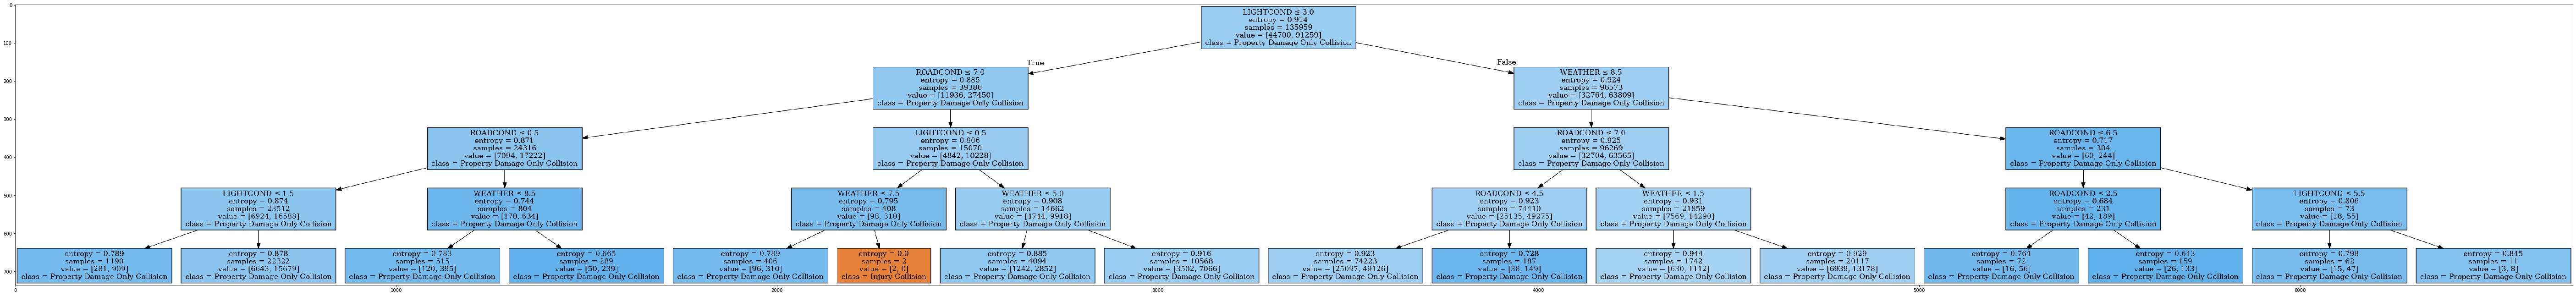

In [34]:
dot_data = StringIO()
filename = "sevtree.png"
featureNames = df.columns[2:5]
targetNames = df["SEVERITYDESC"].unique().tolist()
out=tree.export_graphviz(sevTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

At this point we no longer need SEVERITYDESC filled as our target variable so I will change it to to SEVERITYCODE.  Because this feature is a numerical value that identifies SEVERITYDESC we do not need to use the pandas.get_dummies() function to change SEVERITYDESC to numerical values.

Let's change this now.

In [35]:
y=df['SEVERITYCODE']
y[0:5]

0    2
1    1
2    1
3    1
4    2
Name: SEVERITYCODE, dtype: int64

Now that we have our target variable set as a numerical variable, we can easily create a Confusion Matrix.  This visualization will be helpful to compare our Decision Tree model to our other test models.

To utilize this visualization we need to import it and define parameters for it.

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now let's reset our Train/Test dataset using our new target values.

In [37]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (135959, 3) (135959,)
Test set: (33990, 3) (33990,)


Refit our model

In [38]:
sevTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

And rerun our predictions.

In [39]:
predTree = sevTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

[1 1 1 1 1]
89087     1
18517     1
130679    1
40862     1
73395     1
Name: SEVERITYCODE, dtype: int64


Now we should be able to create our confusion matrix and plot a visual of it.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.68      1.00      0.81     23010
           2       0.00      0.00      0.00     10980

   micro avg       0.68      0.68      0.68     33990
   macro avg       0.34      0.50      0.40     33990
weighted avg       0.46      0.68      0.55     33990

Confusion matrix, without normalization
[[23010     0]
 [10980     0]]


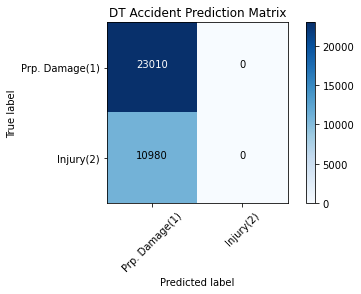

In [40]:
# Compute confusion matrix
DT_matrix = confusion_matrix(y_testset, predTree, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_testset, predTree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_matrix, classes=['Prp. Damage(1)','Injury(2)'],normalize= False,  title='DT Accident Prediction Matrix')

<a id="LogReg"></a>

#### Logistic Regression

[Home](#TOC)

The next classifier we will use is the logistic regression (LR) classifier.  We must define classifer, fit the LR model and predict our test set.

In [41]:

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainset,y_trainset)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
predLR = LR.predict(X_testset)
predLR

array([1, 1, 1, ..., 1, 1, 1])

Now let's take a look at the accuracy of our LR model using jaccard index.

In [43]:
# Compute accuracy
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, predLR)

0.6769638128861429

It is similar to the accuracy of the Decision Tree classifier.

Now it would be nice to have a confusion matrix and plot of it to make it easier to compare metrics to our Decision Tree model.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.68      1.00      0.81     23010
           2       0.00      0.00      0.00     10980

   micro avg       0.68      0.68      0.68     33990
   macro avg       0.34      0.50      0.40     33990
weighted avg       0.46      0.68      0.55     33990

Confusion matrix, without normalization
[[23010     0]
 [10980     0]]


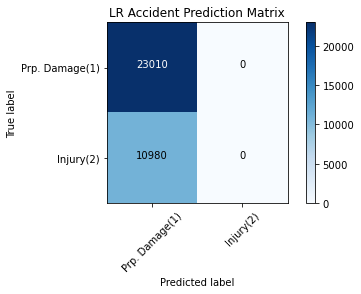

In [44]:
# Compute confusion matrix
LR_matrix = confusion_matrix(y_testset, predLR, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_testset, predLR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_matrix, classes=['Prp. Damage(1)','Injury(2)'],normalize= False,  title='LR Accident Prediction Matrix')

<a id="KNN"></a>

#### K-nearest Neighbor

[Home](#TOC)

The next classifier we will use is the k-nearest neighbor classifier.  We must first define the specific classifer.

We will start by training the model with k=3

In [45]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_trainset,y_trainset)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

We use the model to predict the test set.


In [46]:
predKNN = neigh.predict(X_testset)
predKNN[0:5]

array([2, 1, 1, 1, 1])

Now we can check the accuracy of this K 


In [47]:
print("Train set Accuracy: ", metrics.accuracy_score(y_trainset, neigh.predict(X_trainset)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testset, predKNN))

Train set Accuracy:  0.6446502254356092
Test set Accuracy:  0.6489849955869373


Now let's be more efficient and check multiple Ks at one time. 


In [48]:
Ks = 6
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainset,y_trainset)
    predKNN=neigh.predict(X_testset)
    mean_acc[n-1] = metrics.accuracy_score(y_testset, predKNN)

    
    std_acc[n-1]=np.std(predKNN==y_testset)/np.sqrt(predKNN.shape[0])

mean_acc

array([0.59, 0.65, 0.65, 0.66, 0.59])

Now we can model the accuracy for different numbers of neighbors (Ks) to find the one with the best accuracy.

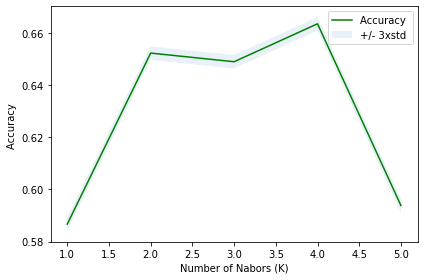

In [49]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [50]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6635481023830538 with k= 4


Let's rerun the model with our most accurate k.

In [51]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_trainset,y_trainset)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

Now let's create our confusion matrix "report" for this model.

              precision    recall  f1-score   support

           1       0.67      0.78      0.72     23010
           2       0.30      0.20      0.24     10980

   micro avg       0.59      0.59      0.59     33990
   macro avg       0.49      0.49      0.48     33990
weighted avg       0.55      0.59      0.57     33990

Confusion matrix, without normalization
[[18004  5006]
 [ 8800  2180]]


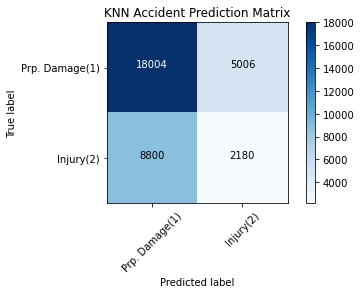

In [52]:
# Compute confusion matrix
KNN_matrix = confusion_matrix(y_testset, predKNN, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_testset, predKNN))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_matrix, classes=['Prp. Damage(1)','Injury(2)'],normalize= False,  title='KNN Accident Prediction Matrix')

<a id="SVM"></a>

#### Support Vector Machines (SVM)

[Home](#TOC)

The next classifier we will use is the Support Vector Machines (SVM) classifier.  We must first define the specific classifer and fit it.

In [53]:

clf = svm.SVC(kernel='rbf')
clf.fit(X_trainset, y_trainset) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

We use the model to predict the test set.

In [54]:
predSVM = clf.predict(X_testset)
predSVM [0:5]

array([1, 1, 1, 1, 1])

Now let's create our confusion matrix "report" for this model.

              precision    recall  f1-score   support

           1       0.68      1.00      0.81     23010
           2       0.40      0.00      0.00     10980

   micro avg       0.68      0.68      0.68     33990
   macro avg       0.54      0.50      0.40     33990
weighted avg       0.59      0.68      0.55     33990

Confusion matrix, without normalization
[[23004     6]
 [10976     4]]


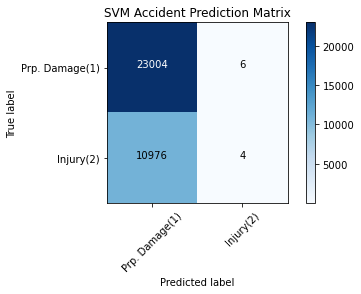

In [55]:
# Compute confusion matrix
SVM_matrix = confusion_matrix(y_testset, predSVM, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_testset, predSVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_matrix, classes=['Prp. Damage(1)','Injury(2)'],normalize= False,  title='SVM Accident Prediction Matrix')

<a id="eval"></a>

## Results

[Home](#TOC)

<a id="SVM"></a>

Let's build a report to show our results in one place.  This will make evaluation easier. 

This report will be based on the jaccard, f-1 score, and log loss from each of our models (algorithms).  

First let's make sure we have our scores for each model identified.

In [56]:
print("Dec. Tree F1-score: %.2f" % f1_score(y_testset, predTree, average='weighted') )
print("Dec. Tree Jaccard index: %.2f" % jaccard_similarity_score(y_testset, predTree))
print('Dec. Tree Log-loss score:', log_loss(y_testset, predTree))
print("Log. Reg. F1-score: %.2f" % f1_score(y_testset, predLR, average='weighted') )
print("Log. Reg. Jaccard index: %.2f" % jaccard_similarity_score(y_testset, predLR))
print('Log. Reg. Log-loss score:', log_loss(y_testset, predLR))
print("KNN F1-score: %.2f" % f1_score(y_testset, predKNN, average='weighted') )
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_testset, predKNN))
print('KNN Log-loss score:', log_loss(y_testset, predKNN))
print("SVM F1-score: %.2f" % f1_score(y_testset, predSVM, average='weighted') )
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_testset, predSVM))
print('SVM Log-loss score:', log_loss(y_testset, predSVM))

Dec. Tree F1-score: 0.55
Dec. Tree Jaccard index: 0.68
Dec. Tree Log-loss score: 23.382043059245763
Log. Reg. F1-score: 0.55
Log. Reg. Jaccard index: 0.68
Log. Reg. Log-loss score: 23.382043059245763
KNN F1-score: 0.57
KNN Jaccard index: 0.59
KNN Log-loss score: 23.382043059245763
SVM F1-score: 0.55
SVM Jaccard index: 0.68
SVM Log-loss score: 23.382043059245763


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
Jaccard = [jaccard_similarity_score(y_testset, predKNN),
           jaccard_similarity_score(y_testset, predTree),
           jaccard_similarity_score(y_testset, predSVM),
           jaccard_similarity_score(y_testset, predLR)]
F1_score = [f1_score(y_testset, predKNN, average='weighted'),
            f1_score(y_testset,predTree,average='weighted'),
            f1_score(y_testset,predSVM,average='weighted'),
            jaccard_similarity_score(y_testset, predLR)]
LogLoss = ['NA','NA','NA',log_loss(y_testset, predLR)]
Notes = ['1','2','3','4']
dfreport = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss, 'Notes': Notes}
dfreport
Report = pd.DataFrame(data=dfreport, columns=['Algorithm','Jaccard', 'F1-score', 'LogLoss'], index=None)
Report.set_index('Algorithm', inplace = True)
Report

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.593822,0.566874,NA
Decision Tree,0.676964,0.546559,NA
SVM,0.676905,0.546748,NA
LogisticRegression,0.676964,0.676964,23.382


<a id="results"></a>

## Discussion & Conclusion

[Home](#TOC)

In this case the Logistic Regression model has similar Jaccard index to Decision Tree and SVM but a higher F-score.  This indicates taht the Logistic Regression model is the most accurate algorithm to uses for the Accident Severity Predictor.